# Model selection: select proper training strategy and regularization parameter with multi-view information

In training session, regvelo provide different training strategy for users, in order to meet different modeling preference or data characters. For "hard" mode, the GRN structure is strictly determined by prior knowledge, which means there no new interaction between genes and TFs can be build. However, for "soft" mode, these interaction are allowed to be build, according to data. The preference between prior knowledge and data character, are weighted by regularization parameter, lambda2. These function are packaged as a class named 'ModelComparison', includes three main functions, "train", "evaluate" and "plot_results".

### Library import

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from scipy.stats import ttest_rel

# RegVelo and related package
import scanpy as sc
import cellrank as cr
import scvi
from regvelo import REGVELOVI
import scvelo as scv
from regvelo import ModelComparison # Import ModelComparison
import regvelo as rgv

# Initialize random seed
scvi.settings.seed = 0

# Data loading
adata = rgv.datasets.zebrafish_nc()
prior_net = rgv.datasets.zebrafish_grn()

# Preprocessing
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

adata = rgv.pp.preprocess_data(adata)
adata = rgv.pp.set_prior_grn(adata,prior_net)

adata

Seed set to 0


AnnData object with n_obs × n_vars = 697 × 988
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'cell_type2', 'macrostates', 'latent_time', 'stage_num', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'is_tf', 'TF', 'velocity_genes', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'macrostates_colors', 'macrostates_fwd_colors', 'neighbors', 'network', 'regulators', 'schur_matrix_fwd', 'skeleton', 'targets', 'term_states_fwd_colors'
    obsm: 'X_pca', 'X_umap', 'macrostates_fwd_memberships', 'schur_vectors_fwd', 'term_states_fwd_memberships'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'latent_time_velovi', 'matrix', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

The adata loaded in this step are after trained. In fact, only preprocessed adata is enough for run this step, because new training session will be done in following steps. Recommand preprocessing steps can be found [here](https://theislab.github.io/regvelo_reproducibility/zebrafish/1_ss3_analysis.html). 

However, in order to evaluate in different perspectives, we recommand you to run following side information compatation step.

### Side information before creating ModelComparison object.
There are several types of information that you may need in following steps. We recommand you to supply all information needed before creating ModelComparison object.

### Pseudotime and Stemness Score.
Pseudotime indicates a simulated timepoint to each cell, ranking them in temporal order. 
Stemness score indicates the differentiation potency of cells, measuring how far a cell is compared to stem cell.
These steps provide pseudotime (via CellRank DPT kernel, see [here](https://theislab.github.io/regvelo_reproducibility/cell_cycle/2_dpt.html)) and stemness score (via CellRank CytoTrace kernel, see [here](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/kernels/400_cytotrace.html)).

In fact, you can also use other methods to compute pseudo time or stemness score for each cell, and store those information in adata.obs. ModelComparison will also get your information in following "evaluate" step.  

These two are not necessary, if you don't use pseudotime or stemness to evaluate model in following steps. 

 

In [2]:
# Diffusion pseudotime computation
## In this step we just consider a random cell whose stage_num is 3 as root cell. You can also use other method to refer your root cell, if you also use DPT method provided by scanpy.
root_cell_name = adata.obs[adata.obs['stage_num'] == 3.0].index[0] # Get cell name
root_ix = np.where(adata.obs_names == root_cell_name)[0][0] # Get cell index
adata.uns["iroot"] = root_ix
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

# Stemness Score computation
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
kernel = 0.8 * vk + 0.2 * ck
ctk = cr.kernels.CytoTRACEKernel(adata).compute_cytotrace()
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

CytoTRACEKernel[n=697, dnorm=False, scheme='soft', b=10.0, nu=0.5]

### Terminal states and transition.

Terminal states is a list recording all potential terminal cell type, given manually by user. This will be used, if you use 'TSI' mode in evaluation, otherwise it is not necessary.

n_STATES refers to the total number of macrostates. Detailed introduction can be found [here](https://theislab.github.io/regvelo_reproducibility/pancreatic_endocrinogenesis/3_comparison_tsi.html) or in following content. This wil be used, if you use 'TSI' mode in evaluation, otherwise it is not necessary.

State_transistion is a list of transition pair, and each element in transition pair must in type of string. Each pair records the orginal state and terminal state of a state transition event. This will be used, if you use 'CBC' mode in evaluation, otherwise it is not necessary. 

In [3]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

n_STATES = 8

STATE_TRANSITION = (('3.0','6.5'),
                    ('6.5','10.0'),
                    ('10.0', '12.5'),
                    ('12.5','17.5'),
                    ('17.5','21.5'))

### ModelComparison: object build.

In [4]:
comp = ModelComparison(terminal_states=TERMINAL_STATES, state_transition=STATE_TRANSITION, n_states=n_STATES)

### ModelComparison: train.

In this step you will begin to train models that you are interested in. All training strategies are stored in model_list. As introduced previously, 'soft' mode enable to create new connection within GRN, 'hard' mode don't. For 'soft_regularized' mode, you can put a series of lambda value in 'lam2' list accompany with soft_regularized models. A larger lambda2 value inficates a bigger preference on current data, and a smaller preference on prior knowledge. You can let model to be trained multiple times under the same circumstance, by ajusting n_repeats, to have multiple output results. Be aware that large number of n_repeats will cause huge amount of training time. 

In [5]:
comp.train(adata,
           model_list=['soft','hard','soft_regularized'],
           lam2=[0.3,0.5,0.8],
           n_repeat=3)

Seed set to 0


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2518.839. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2454.206. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 0
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2489.106. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2371.138. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2260.451. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 0
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2435.288. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2527.615. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2431.752. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2132.919. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2388.154. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2263.319. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2082.085. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2471.712. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your sys

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2485.853. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2333.958. Signaling Trainer to stop.


['soft_0',
 'soft_1',
 'soft_2',
 'hard_0',
 'hard_1',
 'hard_2',
 'soft_regularized\nlam2:0.3_0',
 'soft_regularized\nlam2:0.5_0',
 'soft_regularized\nlam2:0.8_0',
 'soft_regularized\nlam2:0.3_1',
 'soft_regularized\nlam2:0.5_1',
 'soft_regularized\nlam2:0.8_1',
 'soft_regularized\nlam2:0.3_2',
 'soft_regularized\nlam2:0.5_2',
 'soft_regularized\nlam2:0.8_2']

### ModelComparison: evaluate and plotting.

After training, all models has been reserved in the object, so you don't need to train them again and over again when evaluating. Here, we provide five perspectives to evaluate how good those models are. After evaluating, you can plot results by barplot using plot_results, with the best performed model marked and significance bar marked compared between the best one and the others. Significance bar will only be marked if n_repeat >= 3, and the p-value < 0.05 in comparison.

### Real time

If you know the real cell type of each cell, and the temporal sequence of each cell type, you can directly use 'Real_Time' mode. Under this mode, 'side_key' must be provided, stored in adata.obs, which must be a series of float number for calculating spearmann correlation with RegVelo latent time.

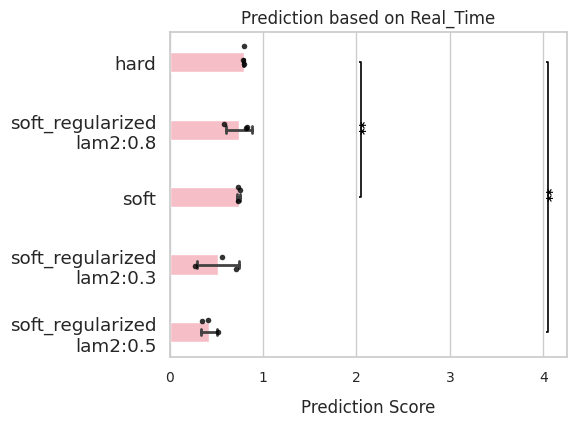

In [6]:
comp.evaluate(side_information='Real_Time',
              side_key='stage_num')
comp.plot_results(side_information='Real_Time')

### Pseudo_Time

If you have computed pseudo time as above, you can use 'Pseudo_Time' mode. Under this mode, 'side_key' will be setted as 'dpt_pseudotime' as default. You can provide any other side key stored in adata.obs, which must be a series of float number for calculating spearmmann correlation with RegVelo latent time.

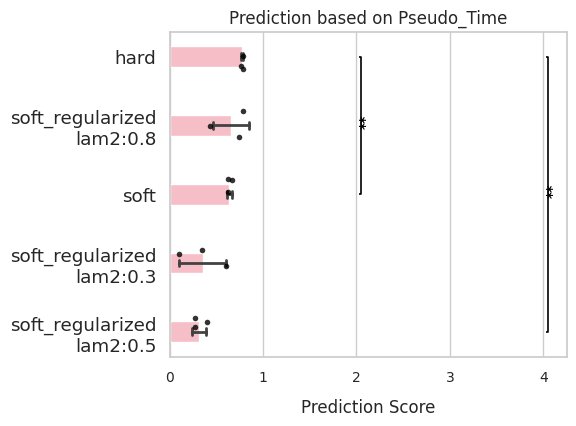

In [7]:
comp.evaluate(side_information='Pseudo_Time')
comp.plot_results(side_information='Pseudo_Time')

### Stemness_Score

If you have computed stemmness score as above, you can use 'Stemness_Score' mode. Under this mode, 'side_key' will be setted as 'ct_score' as default. You can provide any other side key stored in adata.obs, which must be a series of float number for calculating spearmann correlation with RegVelo latent time. 

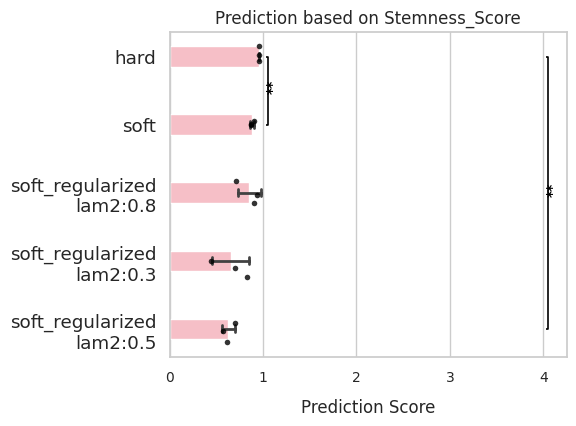

In [8]:
comp.evaluate(side_information='Stemness_Score')
comp.plot_results(side_information='Stemness_Score')

### TSI (Terminal States Identification) score.
Introduction of TSI score can be found [here](https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html#tsi). In short, TSI score evaluate whether the prediction of RegVelo model correspond to given terminal states. Under this mode, 'side_key' must be given manually and used to put into cellrank.estimator.GPCCA.tsi(cluster_key = side_key).

In order to use this mode, terminal states and n_states are necessary when building ModelComparison object.

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

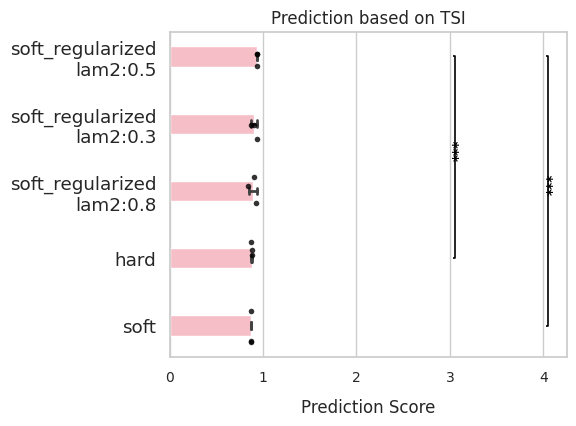

In [9]:
comp.evaluate(side_information='TSI',
              side_key='cell_type')
comp.plot_results(side_information='TSI')

### CBC(Corss boundary correctness) score

Introduction of CBC score can be found [here](https://cellrank.readthedocs.io/en/stable/api/developer.html#cellrank.kernels.Kernel.cbc). In short, CBC score evaluate whether the prediction of RegVelo model is reasonable under each given transition event. Under this mode, 'side_key' must be given manually and used to put into cellrank.kernels.kernel.cbc(cluster_key = side_key). side_key can store either a series of string, or a series of float, because it will be converted into category type in this step. 

In order to use this mode, state transition is necessary when building ModelComparison object, and all element must in string format.

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

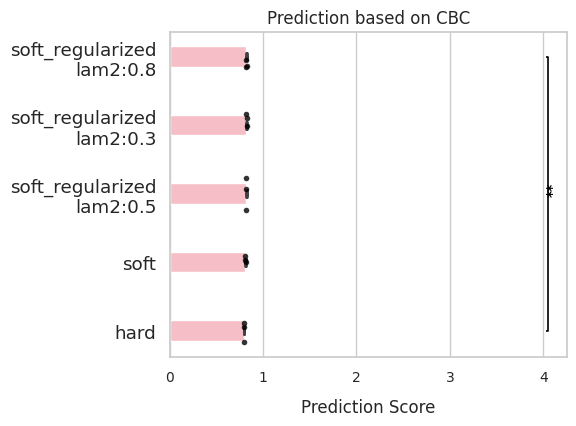

In [10]:
comp.evaluate(side_information='CBC',
              side_key = 'stage_num')
comp.plot_results(side_information='CBC')